# Data loading

In [1]:
!pip install -q fastplot

In [4]:
import pandas as pd
import fastplot
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from scripts import dataset_creation

In [5]:
THRESHOLD = 0.7
df_dataset = pd.read_pickle('datasets/dataset.pkl')
df_pz_sheet, cve_pz = dataset_creation.download_dataset_and_extract_cve_pz()
df_pz = df_dataset[df_dataset['cve'].isin(cve_pz)]
df_kev_sheet, cve_kev = dataset_creation.download_dataset_and_extract_cve_kev()
df_kev = df_dataset[df_dataset['cve'].isin(cve_kev)]

## Project Zero and CISA KEV

In [6]:
def retrieve_cve_by_epss_above_threshold(df):
    df = df.groupby('cve')['epss'].apply(lambda l: l.values.max())
    return df.groupby('cve').filter(lambda v: (v > THRESHOLD).any()).index.values


def filter_df_by_cve_list(df, cve_column_name, cve_list):
    return df[df[cve_column_name].isin(cve_list)]


df_pz_sheet_filtered = df_pz_sheet[['CVE', 'Vendor', 'Product', 'Type']].dropna()
highest_cve_pz = retrieve_cve_by_epss_above_threshold(df_pz)
df_pz_sheet_highest = filter_df_by_cve_list(df_pz_sheet_filtered, 'CVE', highest_cve_pz)

df_kev_sheet_filtered = df_kev_sheet[['cveID', 'vendorProject', 'product', 'vulnerabilityName']]
highest_cve_kev = retrieve_cve_by_epss_above_threshold(df_kev)
df_kev_sheet_highest = filter_df_by_cve_list(df_kev_sheet_filtered, 'cveID', highest_cve_kev)

### Distribution of CVEs that exceed the threshold vs vendor, product, type of vulnerability for Project Zero

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

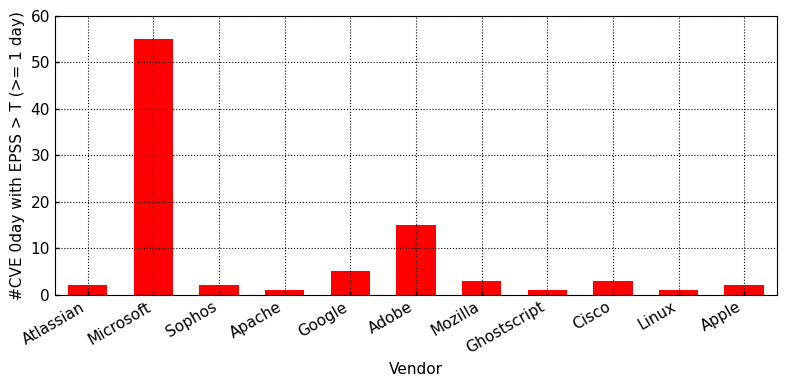

In [7]:
vendors = list(df_pz_sheet_highest['Vendor'].unique())
data = [(v, len(df_pz_sheet_highest[df_pz_sheet_highest['Vendor'] == v])) for v in vendors]
fastplot.plot(data, None, mode='bars', xlabel='Vendor', ylabel='#CVE 0day with EPSS > T (>= 1 day)',
              xticks_rotate=30, figsize=(8, 4), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

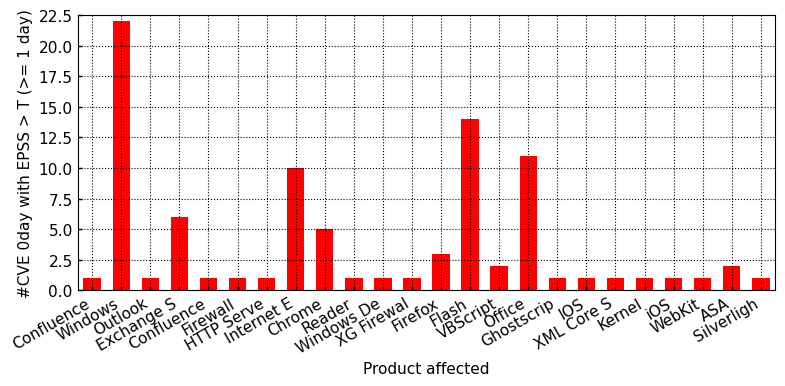

In [8]:
products = list(df_pz_sheet_highest['Product'].unique())
data = [(p[:10], len(df_pz_sheet_highest[df_pz_sheet_highest['Product'] == p])) for p in products]
fastplot.plot(data, None, mode='bars', xlabel='Product affected', ylabel='#CVE 0day with EPSS > T (>= 1 day)',
              xticks_rotate=30, figsize=(8, 4), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

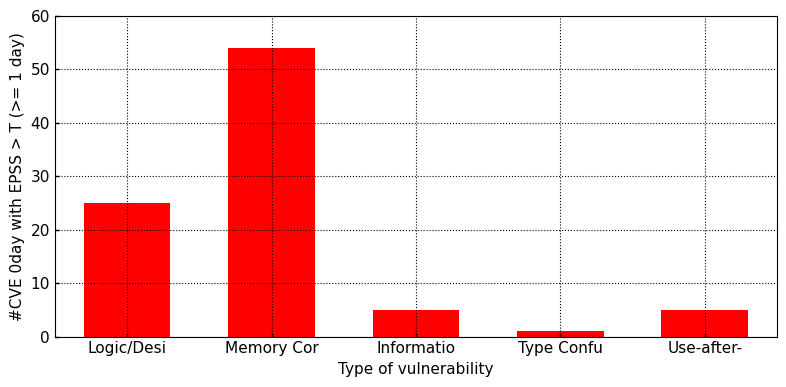

In [9]:
types = list(df_pz_sheet_highest['Type'].unique())
data = [(t[:10], len(df_pz_sheet_highest[df_pz_sheet_highest['Type'] == t])) for t in types]
fastplot.plot(data, None, mode='bars', xlabel='Type of vulnerability',
              ylabel='#CVE 0day with EPSS > T (>= 1 day)', figsize=(8, 4), grid=True)

### Distribution of CVEs that exceed the threshold vs vendor, product for CISA KEV

In [10]:
def group_values_with_less_frequency(tuples_list, keep_other=False):
    sum_of_ones = 0
    other_tuples = []
    for string, num in tuples_list:
        if num == 1:
            sum_of_ones += 1
        else:
            other_tuples.append((string, num))
    if sum_of_ones > 0 and keep_other == True:
        other_tuples.append(('Other', sum_of_ones))
    return other_tuples

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

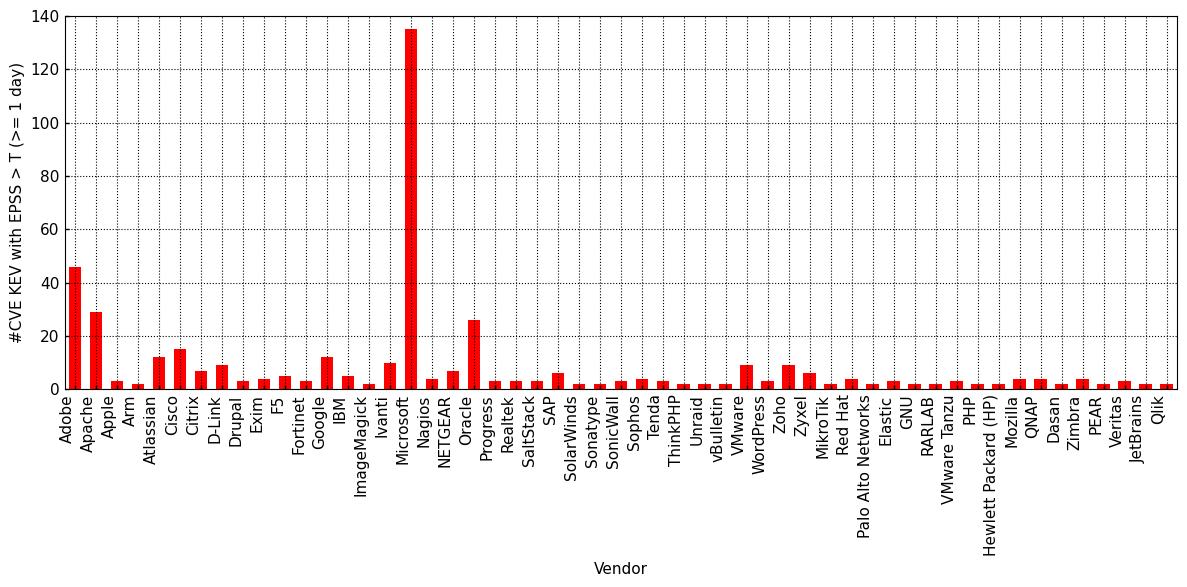

In [11]:
vendors = list(df_kev_sheet_highest['vendorProject'].unique())
data = [(v, len(df_kev_sheet_highest[df_kev_sheet_highest['vendorProject'] == v])) for v in vendors]
data = group_values_with_less_frequency(data)
fastplot.plot(data, None, mode='bars', xlabel='Vendor', ylabel='#CVE KEV with EPSS > T (>= 1 day)',
              xticks_rotate=90, figsize=(12, 6), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

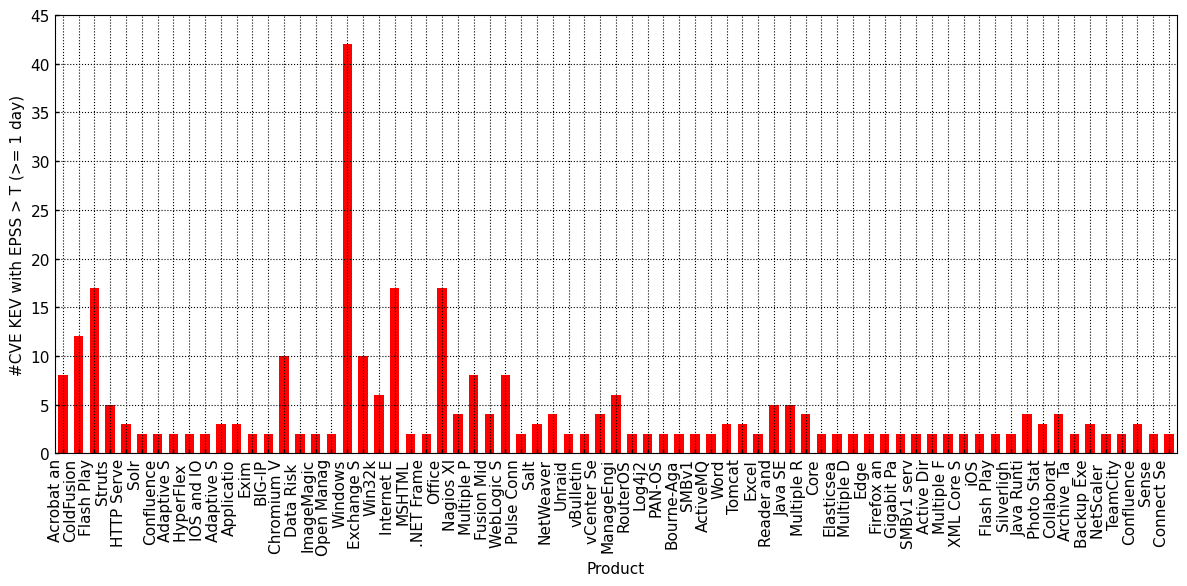

In [12]:
products = list(df_kev_sheet_highest['product'].unique())
data = [(p[:10], len(df_kev_sheet_highest[df_kev_sheet_highest['product'] == p])) for p in products]
data = group_values_with_less_frequency(data)
fastplot.plot(data, None, mode='bars', xlabel='Product', ylabel='#CVE KEV with EPSS > T (>= 1 day)',
              xticks_rotate=90, figsize=(12, 6), grid=True)

## hackthebox - Most popular CVEs from 2022

In [13]:
# Extract CVEs list from the website
data = requests.get('https://www.hackthebox.com/blog/most-popular-cybersecurity-vulnerabilities-and-exploits-from-2022')
soup = BeautifulSoup(data.text, 'html.parser')
table_cells = soup.find_all('td')
cve_hackthebox = []
for cell in table_cells:
    paragraphs = cell.find_all('p')
    for paragraph in paragraphs:
        links = paragraph.find_all('a')
        for link in links:
            cve_id = link.text
            if 'cve' in cve_id:
                cve_hackthebox.append(cve_id.upper())